In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import Set
from pathlib import Path



warnings.filterwarnings("ignore")

**Vorschlag Zielwert ZQ Synergy**

$PE(GFZ)= min( 1,63*(\frac{35.2}{GFZ+0,15}-27.3) ; 100) $     $[kWh_{PE}/m²_{BGF}a]$

In [66]:
# ZQ Austria Vorschlag

GFZ = np.linspace(0.0, 8, 800) #min, max, steps
def target(
        GFZ=GFZ,
        fPE=1.63, # OIB 2019 Jahresmittel
        A=35.2,
        dx=0.15,
        EUI=27.3,
        cutoff=100,
        scale=1
) -> pd.DataFrame:
    curve = (fPE * (A/(dx + GFZ) - EUI )) * scale
    return np.minimum(curve, cutoff) if cutoff else curve

In [67]:
PEQ_alfa = pd.DataFrame({
    "Positive Energy Balance":np.zeros(len(GFZ)),
    "ZQ1 Endbericht":target(GFZ, A=37, dx=0.085,EUI=29.14, cutoff=None),
    "ZQ1 Formel (auf NGF bezogen)":
        target(GFZ, A=37, dx=0.085,EUI=29.14, fPE=1.63*0.8, cutoff=None),
    "Vorschlag ZQ Synergy": target(GFZ),
}, index=GFZ)


In [127]:
def plot_context_factor(ax, df, ylims=(-75,150), xlims=(0,8), no_legend=False):
    if no_legend: # names with leading underscore dont show
        df.columns = ["_" + col for col in df.columns]
    df.plot(ax=ax, linestyle="solid", linewidth=1, )
    ax.set_ylim(*ylims); ax.set_xlim(*xlims)
    ax.set_ylabel("PE-Balance $[{kWh/m²_{BGF}a}]$")
    ax.set_xlabel("Floor space index")
    ax.grid()

    #ax.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')

C:\Users\Simon Schneider\anaconda\envs\pyped\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002222A27F6D0> has a label of '__________Positive Energy Balance' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\Simon Schneider\anaconda\envs\pyped\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002222A27F760> has a label of '__________ZQ1 Endbericht' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\Simon Schneider\anaconda\envs\pyped\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002222C9543A0> has a label of '__________ZQ1 Formel (auf NGF bezogen)' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", 

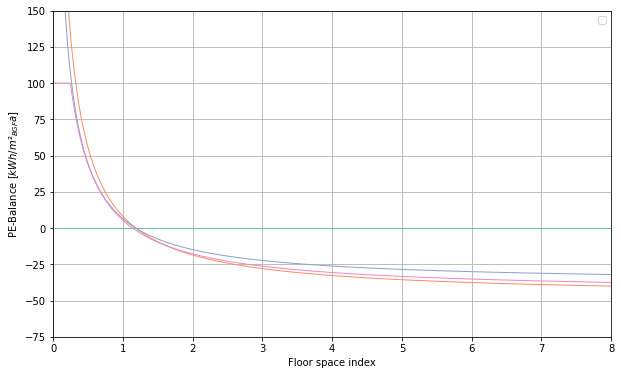

In [129]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plot_context_factor(ax, df=PEQ_alfa)

Specify excel path

In [6]:
path = Path(r"C:\Users\Simon Schneider\Nextcloud\EE\1_Forschung\2_Laufend\Plusenergie-Campus Energybase 2.0 (Sdz 9)\4_Quartier\PEExcel_final\PEC Varianten.xlsx")

df = pd.read_excel(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Columns: 376 entries, Name to auf Straßen/Gehwegen
dtypes: bool(13), float64(250), int64(93), object(20)
memory usage: 2.2+ MB


Identify the required columns

In [14]:
df.columns

Index(['Name', 'Quartier', 'Forschungsprojekt', 'Land', 'Stadt', 'Variante',
       'Beschreibung', 'Mikroquartier', 'Gebäudehülle', 'Lüftung mit WRG',
       ...
       'GFZ.1', 'Primärenergiesaldo ohne Dichteausgleich.1',
       'PE-Saldo Ziel NGF.1',
       'PE-Anforderung erreicht? Werte inkl. Dichtebonus.1',
       'PE-Saldo Ziel BGF default (NGF/BGF=0,8).1',
       'PE-Saldo Ziel BGF real (NGF/BGF=0,85).1', 'Heizenergie [MWh/a]',
       'Kühlenergie [MWh/a]', 'Umweltenergiepotential auf Grundstück [MWh/a]',
       'auf Straßen/Gehwegen'],
      dtype='object', length=376)

In [174]:
available = set(df.columns)

PEB_varname = "Primärenergiesaldo ohne Dichteausgleich.1"
required = {
    "Name",

    "Mikroquartier",
    "Gebäudehülle",
    "Lüftung mit WRG",
    "PV",
    "JAZ",
    "Reduktion Nutzerstrom",
    "ecars",
    "WPS",
    "Klima",

    "GFZ",
    PEB_varname,
    'PE-Saldo Ziel BGF default (NGF/BGF=0,8).1',
    'Heizenergie [MWh/a]',
    'Kühlenergie [MWh/a]',
    'Umweltenergiepotential auf Grundstück [MWh/a]',

}

print("missing columns:\n", required - available)

missing columns:
 set()


In [65]:
for c in df.columns:
    if "PE" in c:
        print(c)

PEBedarf
CO2,PE Profil
PEBedarf.1
PEExport
PESaldo
PEBedarf.2
PEExport.1
PESaldo.1
PEBedarf.3
PEExport.2
PESaldo.2
PE-Saldo Ziel NGF
PE-Anforderung erreicht? Werte inkl. Dichtebonus
PE-Saldo Ziel BGF default (NGF/BGF=0,8)
PE-Saldo Ziel BGF real (NGF/BGF=0,85)
PEBedarf.4
PEExport.3
PESaldo.3
PE-Saldo Ziel NGF.1
PE-Anforderung erreicht? Werte inkl. Dichtebonus.1
PE-Saldo Ziel BGF default (NGF/BGF=0,8).1
PE-Saldo Ziel BGF real (NGF/BGF=0,85).1


<AxesSubplot:xlabel='Floor space index', ylabel='PE-Balance $[{kWh/m²_{BGF}a}]$'>

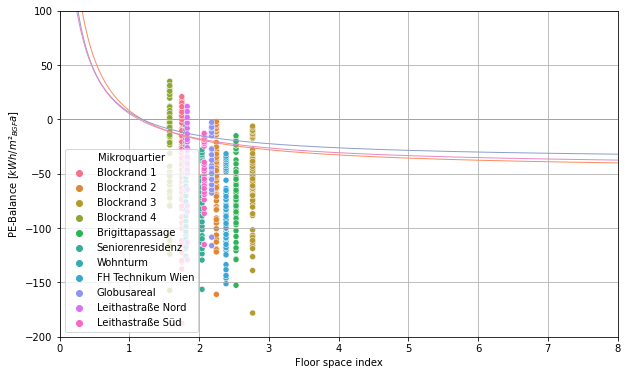

In [137]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plot_context_factor(ax, df=PEQ_alfa, ylims=(-200,100))
sns.set_palette("Set2") #"Reds"
sns.scatterplot(ax=ax,
                x="GFZ",
                y=PEB_varname,
                hue="Mikroquartier",
                data=df)

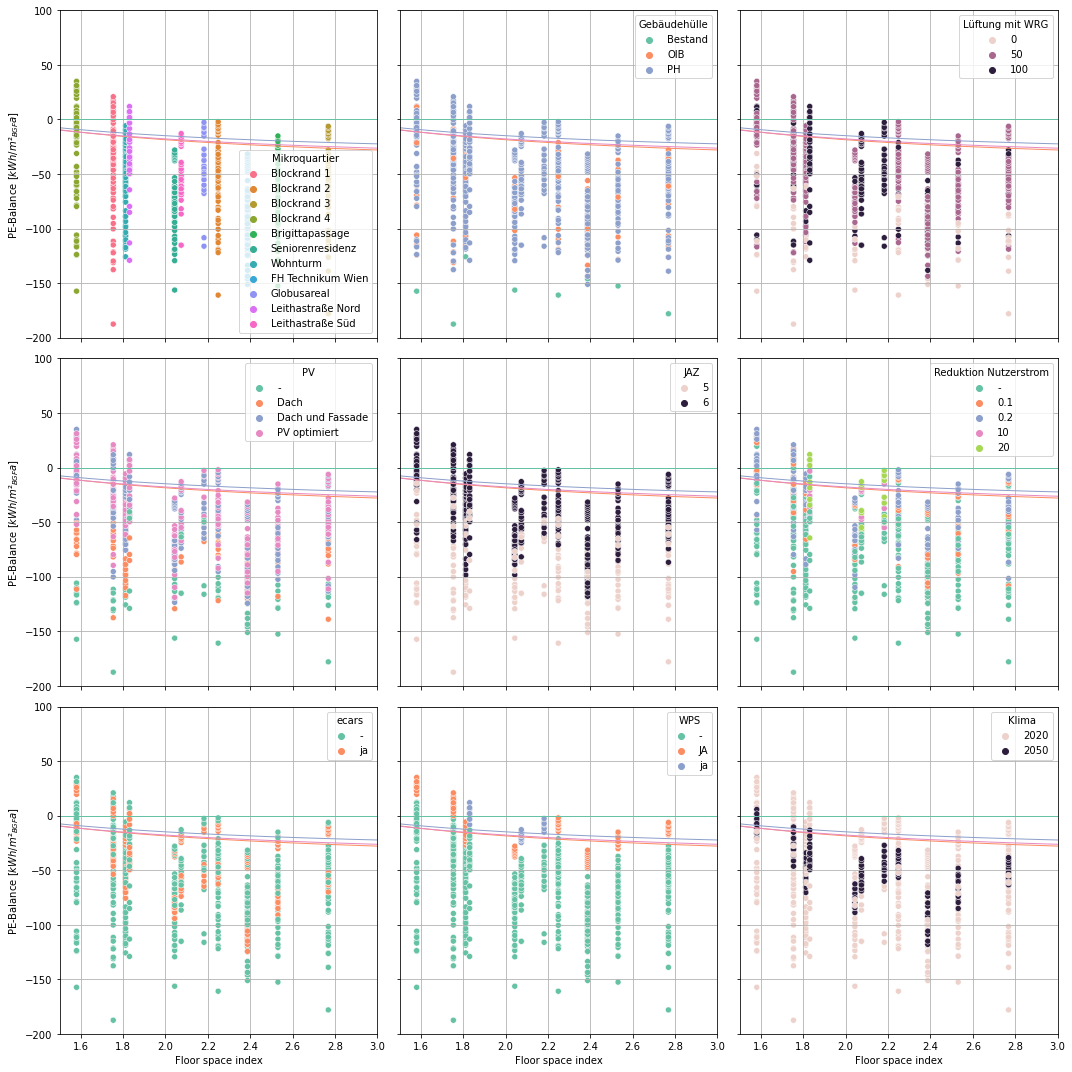

In [132]:
subplot_columns = [
    "Mikroquartier",
    "Gebäudehülle",
    "Lüftung mit WRG",
    "PV",
    "JAZ",
    "Reduktion Nutzerstrom",
    "ecars",
    "WPS",
    "Klima"]

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
for ax, category in zip(axes.flatten(), subplot_columns):
    plot_context_factor(ax,
                        df=PEQ_alfa,
                        ylims=(-200,100),
                        xlims=(1.5,3),
                        no_legend=True
                        )
    sns.scatterplot(ax=ax,
                    x="GFZ",
                    y=PEB_varname,
                    hue=category,
                    data=df)
plt.tight_layout()

In [175]:
dfmin = df[required]
dfmin.columns

Index(['Reduktion Nutzerstrom', 'Primärenergiesaldo ohne Dichteausgleich.1',
       'Heizenergie [MWh/a]', 'Name', 'ecars',
       'Umweltenergiepotential auf Grundstück [MWh/a]', 'GFZ',
       'Lüftung mit WRG', 'Gebäudehülle', 'WPS', 'Mikroquartier', 'JAZ', 'PV',
       'Klima', 'PE-Saldo Ziel BGF default (NGF/BGF=0,8).1',
       'Kühlenergie [MWh/a]'],
      dtype='object')

<AxesSubplot:xlabel='PE-Saldo Ziel BGF default (NGF/BGF=0,8).1', ylabel='Mikroquartier'>

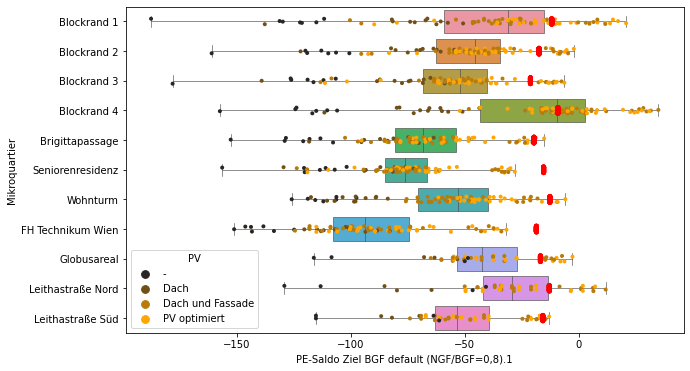

In [164]:
fig, ax = plt.subplots(1,1, figsize=(10,6))


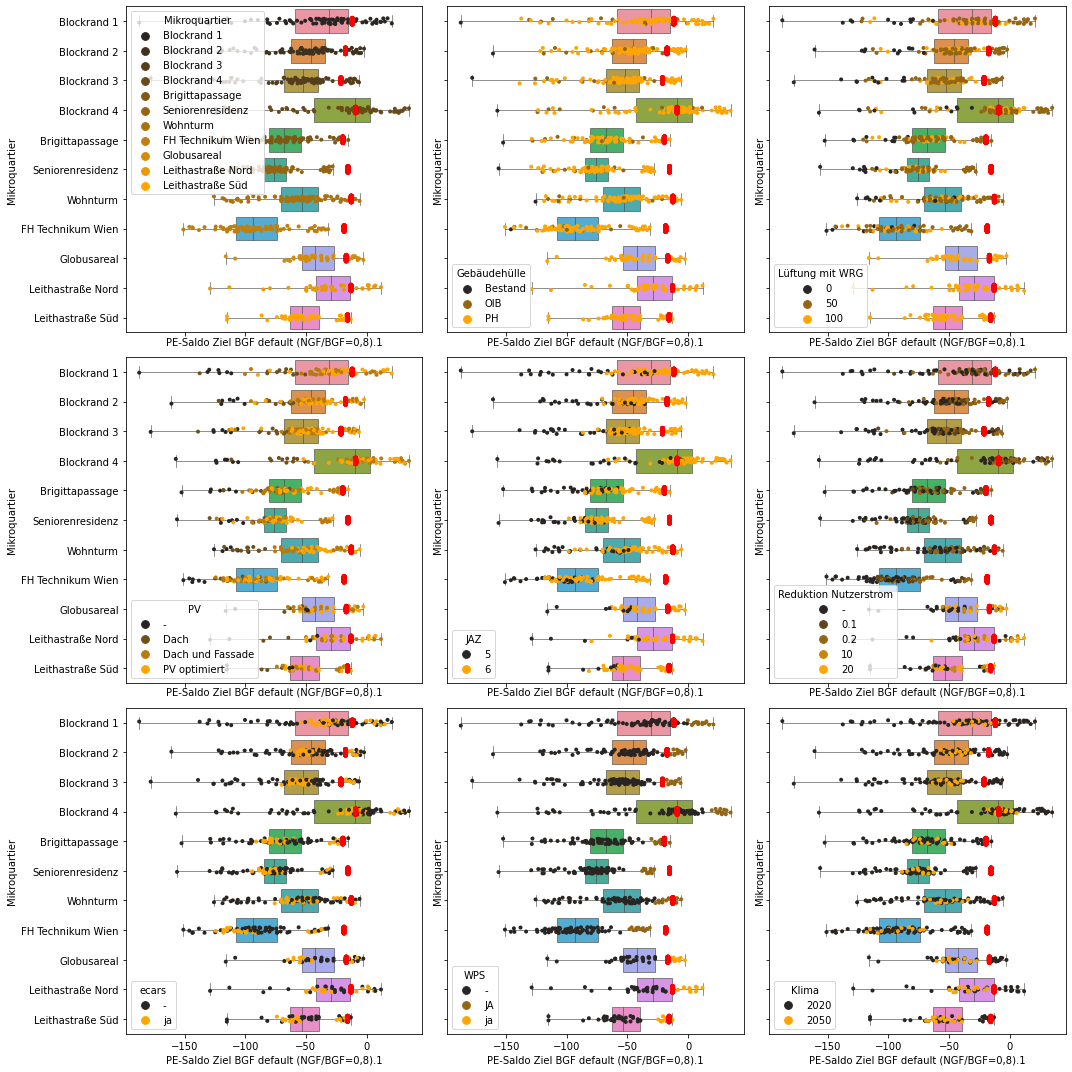

In [167]:
fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
for ax, category in zip(axes.flatten(), subplot_columns):
    sns.boxplot(ax=ax, data=dfmin,
                x=PEB_varname, y="Mikroquartier",
                whis=[0, 100], width=.8, linewidth=0.6
                )

    sns.stripplot(ax=ax, x=PEB_varname, y="Mikroquartier",
              data=dfmin, hue=category, color="orange",
              size=4, linewidth=0)

    sns.stripplot(ax=ax, x='PE-Saldo Ziel BGF default (NGF/BGF=0,8).1', y="Mikroquartier",
              data=dfmin, color="red",
              size=5, linewidth=0)
plt.tight_layout()

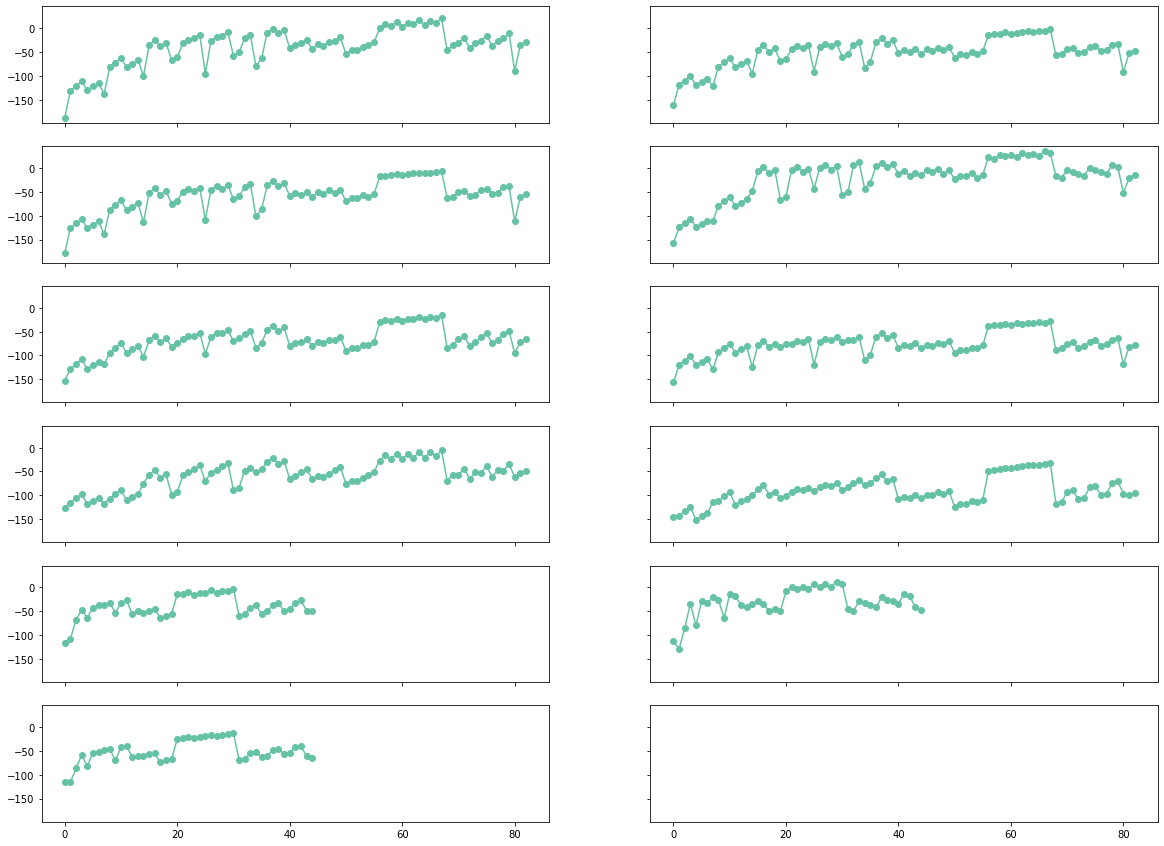

In [192]:
fig, axes = plt.subplots(6,2, figsize=(20,15), sharex=True, sharey=True)
for ax, mqs in zip(axes.flatten(), dfmin.Mikroquartier.unique()):
    ax.plot(np.arange(len(dfmin[dfmin.Mikroquartier==mqs])), PEB_varname,
    data=dfmin[dfmin.Mikroquartier==mqs], linestyle='-', marker='o')


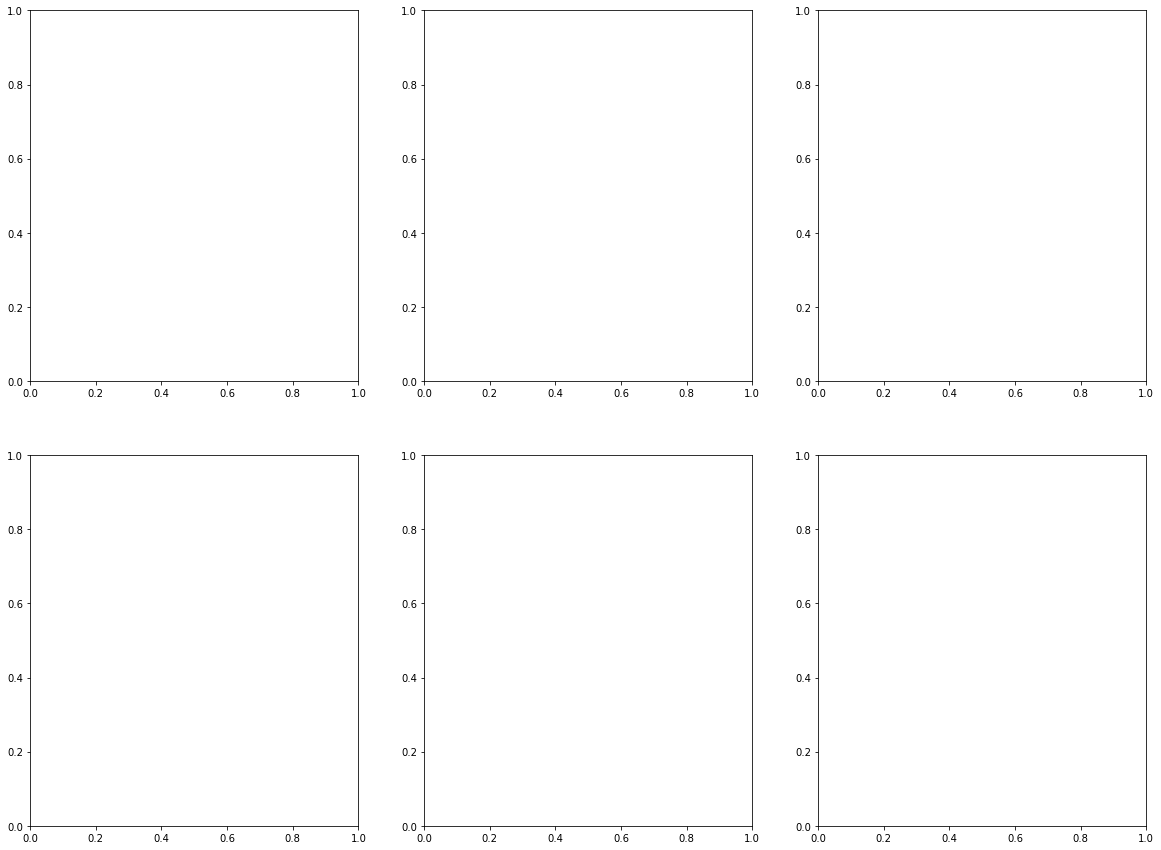

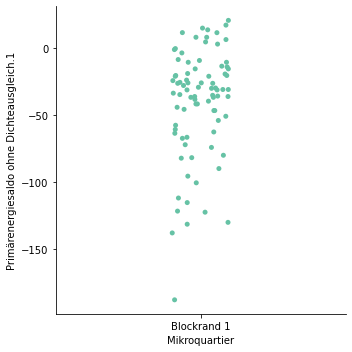

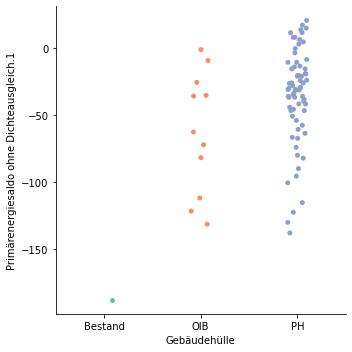

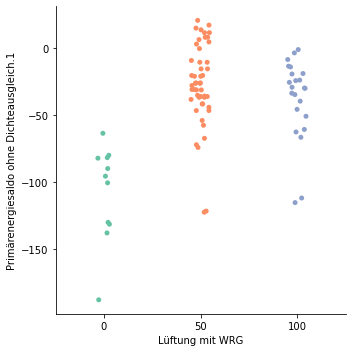

In [219]:
b1 = dfmin[dfmin.Mikroquartier=="Blockrand 1"]
mq_count = 2 #dfmin.Mikroquartier.unique()
cat_count = len(subplot_columns[:3])

fig, axes = plt.subplots(mq_count,cat_count, figsize=(20,15))
for axcol, cat in enumerate(subplot_columns[:3]):
    sns.catplot(ax=axes[0, axcol],
                x=cat,
                y=PEB_varname,
                order=b1[cat].unique(),
                data=b1)

In [214]:

df.count
    'Heizenergie [MWh/a]',
    'Kühlenergie [MWh/a]',
    'Umweltenergiepotential auf Grundstück [MWh/a]',

array(['-', 'Dach', 'Dach und Fassade', 'PV optimiert'], dtype=object)